# Лабораторная работа № 4. Латентное размещение Дирихле

In [2]:
import numpy as np
import pandas as pd

В этой лабораторной работе мы будем работать со [сценариями кинофильмов на английском языке](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

Загрузите данные и положите их в ту же папку, что и ноутбук с заданием.

In [3]:
dataset_path = "/kaggle/input/wikipedia-movie-plots/"

In [4]:
rawdata = pd.read_csv(dataset_path + "wiki_movie_plots_deduped.csv")

Прежде чем строить тематическую модель, нужно подготовить данные. Сейчас документы выглядят вот так:

In [5]:
for plot in rawdata.Plot.sample(2):
    print(plot, "\n")

Sam Wheat, a banker, and his girlfriend Molly Jensen, a potter, renovate and move into an apartment in Manhattan with the help of Sam's friend and co-worker Carl Bruner. One afternoon, Sam confides in Carl his discovery of unusually high balances in obscure bank accounts. He decides to investigate the matter himself, declining Carl's offer of assistance. That night, Sam and Molly are attacked by a mugger who kills Sam in a scuffle before stealing his wallet. Sam sees Molly crying over his body and discovers he is now a ghost; invisible and unable to interact with the mortal world.
Molly remains distraught in the days after Sam's death, as Sam remains close to her. Carl comes over and suggests Molly take a walk with him and Sam cannot bring himself to follow. Moments later, the mugger enters the apartment in search of something. When Molly returns, Sam scares their cat into attacking the thug, who flees. Sam follows the mugger to his Brooklyn apartment and learns that the man, Willie Lo

В тематической модели LDA порядок слов в документе никак не учитывается, важно лишь какие слова и сколько раз встречались в документе. Поэтому далее для обучения модели мы будем использовать представление текста в виде [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)

Для начала нужно выкинуть из текстов все лишнее, кроме слов: пунктуацию, числа и т.п. Для этого применим стандартную процедуру [токенизации](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): 
* разобьем исходные документы-строки на токены
* отбросим все токены, кроме слов 
* соединим токены-слова обратно в строку, для удобства хранения (списки в Python занимают много памяти)

In [6]:
from nltk.tokenize import word_tokenize

data = rawdata.Plot.apply(lambda x: " ".join(list(filter(str.isalpha, word_tokenize(x.lower())))))

In [7]:
data.head(5)

0    a bartender is working at a saloon serving dri...
1    the moon painted with a smiling face hangs ove...
2    the film just over a minute long is composed o...
3    lasting just seconds and consisting of two sho...
4    the earliest known adaptation of the classic f...
Name: Plot, dtype: object

Теперь приведем все слова к начальной форме, чтобы уменьшить размер словаря. Это делается с помощью процедуры [лемматизации](https://en.wikipedia.org/wiki/Lemmatisation)

In [10]:
from nltk.stem import WordNetLemmatizer 
import nltk
import zipfile
import os


nltk.download('wordnet', download_dir='/root/nltk_data')
nltk_data_path = '/root/nltk_data'
wordnet_zip_path = os.path.join(nltk_data_path, 'corpora', 'wordnet.zip')
target_path = os.path.join(nltk_data_path, 'corpora')

# Распаковка
if os.path.exists(wordnet_zip_path):
    with zipfile.ZipFile(wordnet_zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_path)
    print("Файл wordnet успешно распакован!")
else:
    print("Файл wordnet.zip не найден!")

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
Файл wordnet успешно распакован!


In [11]:
data = data.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))

Вот как теперь выглядят наши тексты

In [12]:
print(data.sample(1).values[0])

parsifal katzenellenbogen tony curtis is an eccentric hypochondriac who ha invented a laser skywriter parsifal invite businessmen to his castle in the hope of selling his invention potential buyer include gangster henry board ii erik estrada accompanied by movie star montague chippendale peter lawford scotsman mackintosh donald pleasence and gypsy klingsor orson welles


Воспользуемся [библиотекой для визуализации текстовых данных](https://github.com/amueller/word_cloud), чтобы нагляднее посмотреть, из каких слов состоят документы

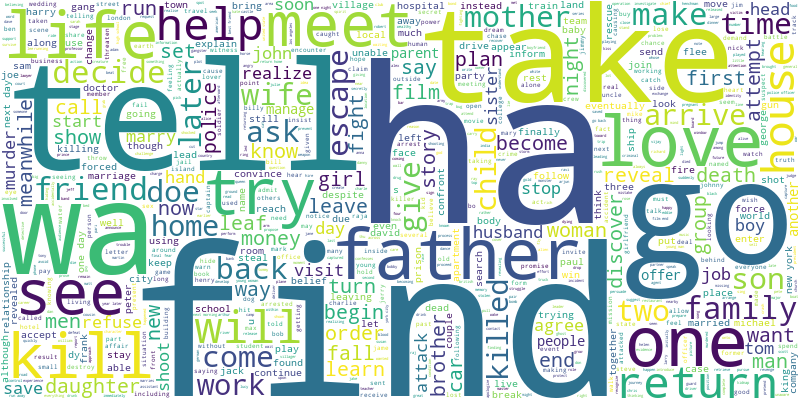

In [13]:
from wordcloud import WordCloud

all_texts = ','.join(list(data.values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)

wordcloud.generate(all_texts)
wordcloud.to_image()

Теперь создадим bag of words. При его создании мы не будем добавлять в словарь стоп-слова -- служебные части речи, которые присутствуют в подавляющем большинстве текстов, и потому не несут значимой информативной нагрузки

In [14]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['ha', 'wa'])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В стоп-слова добавлены 'ha' и 'wa' потому что в них лемматизатор превращает слова has и was

Воспользуемся [BOW из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Слова, которые встречаются слишком редко (в небольшом числе документов) мы тоже отбросим, чтобы не перегружать словарь

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
count_vectorizer = CountVectorizer(stop_words=list(stop_words), min_df=10)
count_data = count_vectorizer.fit_transform(data.values)

Посмотрим на распределение слов в нашем корпусе текстов

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_most_common_words(count_data, count_vectorizer, n_words):
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90, fontsize=15) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

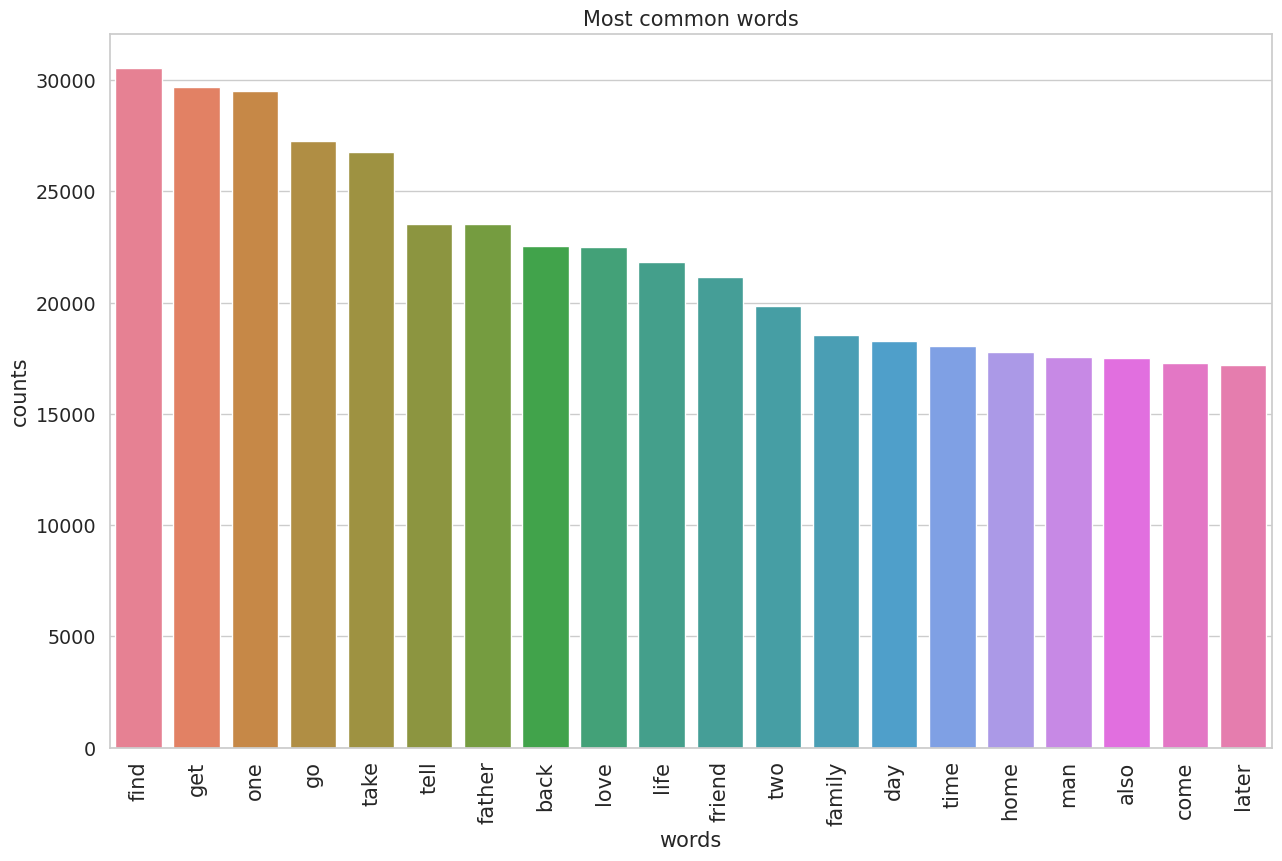

In [24]:
plot_most_common_words(count_data, count_vectorizer, 20)

## Стандартная модель LDA

Теперь приступим к обучению модели. Для начала обучим стандартную модель LDA.

**Задание 1**

Изучите [модель LDA из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) и обучите её на подготовленных данных. Посмотрите на распределения слов в темах, выведите наиболее вероятные слова для каждой темы

Вспомагательная функция для визуализации самых вероятных слов в темах:

In [28]:
def print_topics(count_vectorizer, phi_matrix, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(phi_matrix):
        print("\nTopic #{}".format(topic_idx))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [31]:
from sklearn.decomposition import LatentDirichletAllocation
import logging
logging.basicConfig(level=logging.INFO)

# Установим логгер sklearn на уровень INFO
logging.getLogger("sklearn.decomposition").setLevel(logging.INFO)

n_topics = 10 
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=10, 
                                learning_method='online',
                                random_state=42,
                                n_jobs=-1, verbose=1)

lda.fit(count_data)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=42,
                          verbose=1)

In [32]:
# Матрица распределений слов по темам
phi_matrix = lda.components_

# Наиболее вероятные слова для каждой темы
print_topics(count_vectorizer, phi_matrix, n_top_words=10)


Topic #0
tom get sam money kill go take fight bank find

Topic #1
king love film anna lord prince london return life queen

Topic #2
new film show school paul john work job go make

Topic #3
police murder man find death wife kill case one killed

Topic #4
kill team escape men gang shoot car killed gun game

Topic #5
find house back go tell see night room one body

Topic #6
raja peter get george charlie money arjun jimmy henry billy

Topic #7
father family child one life mother son boy man home

Topic #8
ship war soldier army force attack island captain crew battle

Topic #9
love get father friend family come life son marriage day


In [38]:
# Получение распределения тем для документов
topic_distribution = lda.transform(count_data)

dominant_topics = topic_distribution.argmax(axis=1)

rawdata['dominant_topic'] = dominant_topics
print(rawdata[['Plot', 'dominant_topic']].head())

                                                Plot  dominant_topic
0  A bartender is working at a saloon, serving dr...               2
1  The moon, painted with a smiling face hangs ov...               5
2  The film, just over a minute long, is composed...               7
3  Lasting just 61 seconds and consisting of two ...               5
4  The earliest known adaptation of the classic f...               7


In [41]:
!pip install --upgrade jupyter traitlets matplotlib-inline
!pip install --upgrade seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: jupyter-lsp
    Found existing installation: jupyter-lsp 1.5.1
    Uninstalling jupyter-lsp-1.5.1:
      Successfully uninstalled jupyter-lsp-1.5.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


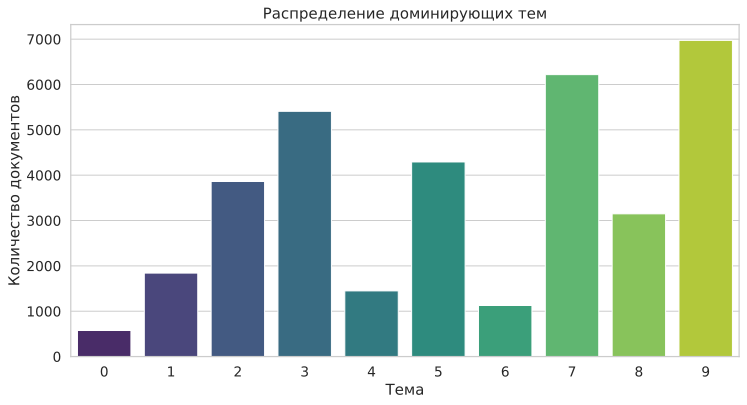

In [43]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="seaborn._oldcore")

%matplotlib inline
%config InlineBackend.figure_format = "svg"

plt.figure(figsize=(12,6))
sns.countplot(x='dominant_topic', data=rawdata, palette='viridis')
plt.title('Распределение доминирующих тем')
plt.xlabel('Тема')
plt.ylabel('Количество документов')
plt.show()

In [46]:
n_top_words = 10
topics = []

for topic_idx, topic in enumerate(phi_matrix):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [count_vectorizer.get_feature_names_out()[i] for i in top_features_ind]
    topics.append(top_features)

topics_df = pd.DataFrame(topics, columns=[f"Слово {i+1}" for i in range(n_top_words)])
topics_df.index.name = 'Тема'
print(topics_df)

     Слово 1 Слово 2  Слово 3 Слово 4  Слово 5 Слово 6 Слово 7  Слово 8  \
Тема                                                                      
0        tom     get      sam   money     kill      go    take    fight   
1       king    love     film    anna     lord  prince  london   return   
2        new    film     show  school     paul    john    work      job   
3     police  murder      man    find    death    wife    kill     case   
4       kill    team   escape     men     gang   shoot     car   killed   
5       find   house     back      go     tell     see   night     room   
6       raja   peter      get  george  charlie   money   arjun    jimmy   
7     father  family    child     one     life  mother     son      boy   
8       ship     war  soldier    army    force  attack  island  captain   
9       love     get   father  friend   family    come    life      son   

       Слово 9 Слово 10  
Тема                     
0         bank     find  
1         life    que

**Задание 2** 

Часто бывает так, что в LDA выделяется одна или несколько тем с общей лексикой -- т.е. со словами, которые часто встречаются в большом количестве документов корпуса. Проанализируйте полученные в LDA темы и найдите в выделенных темах те, в которые собрались слова общей лексики (или покажите, что таких тем нет). Для этого можно, например:
* проанализировать встречаемость каждой темы в документах, посмотреть на среднее/дисперсию/распределение вероятностей каждой темы в корпусе документов
* посмотреть на встречаемость самых частых слов корпуса в темах

In [49]:
topic_means = topic_distribution.mean(axis=0)
topic_std = topic_distribution.std(axis=0)

topic_stats = pd.DataFrame({
    'Тема': range(n_topics),
    'Среднее': topic_means,
    'Стандартное отклонение': topic_std
})

print(topic_stats)

   Тема   Среднее  Стандартное отклонение
0     0  0.047201                0.072640
1     1  0.075387                0.108481
2     2  0.106998                0.124833
3     3  0.147745                0.143517
4     4  0.066831                0.090218
5     5  0.118633                0.132075
6     6  0.057064                0.085414
7     7  0.167234                0.142183
8     8  0.076903                0.122985
9     9  0.136005                0.211396


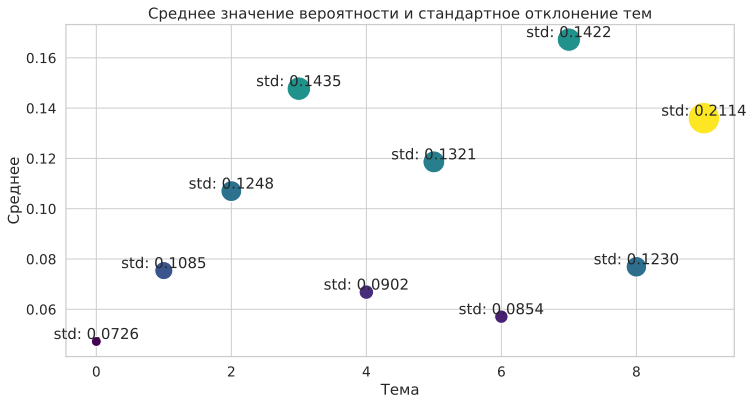

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=topic_stats, x='Тема', y='Среднее', size='Стандартное отклонение', 
                hue='Стандартное отклонение', palette='viridis', sizes=(100, 1000), legend=False)
for i in range(n_topics):
    plt.text(topic_stats['Тема'][i], topic_stats['Среднее'][i]+0.001, 
             f"std: {topic_stats['Стандартное отклонение'][i]:.4f}", horizontalalignment='center')
plt.title('Среднее значение вероятности и стандартное отклонение тем')
plt.xlabel('Тема')
plt.ylabel('Среднее')
plt.show()

In [54]:
# Получение общей частоты слов в корпусе
word_counts = np.asarray(count_data.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({
    'word': count_vectorizer.get_feature_names_out(),
    'count': word_counts
}).sort_values(by='count', ascending=False)

N = 100
top_n_words = word_freq_df.head(N)['word'].tolist()
print(f"Топ {N} наиболее частых слов в корпусе:")
print(top_n_words)

Топ 100 наиболее частых слов в корпусе:
['find', 'get', 'one', 'go', 'take', 'tell', 'father', 'back', 'love', 'life', 'friend', 'two', 'family', 'day', 'time', 'home', 'man', 'also', 'come', 'later', 'house', 'return', 'kill', 'police', 'new', 'make', 'try', 'meet', 'see', 'help', 'mother', 'however', 'son', 'film', 'wife', 'doe', 'end', 'woman', 'away', 'give', 'daughter', 'year', 'begin', 'girl', 'money', 'death', 'escape', 'child', 'night', 'fall', 'killed', 'brother', 'first', 'work', 'young', 'way', 'attempt', 'car', 'want', 'men', 'story', 'becomes', 'next', 'decides', 'run', 'leaf', 'plan', 'another', 'leave', 'asks', 'start', 'show', 'turn', 'order', 'meanwhile', 'fight', 'call', 'soon', 'school', 'know', 'named', 'boy', 'group', 'arrives', 'finally', 'set', 'sister', 'town', 'three', 'reveals', 'say', 'room', 'eventually', 'attack', 'john', 'head', 'job', 'husband', 'old', 'would']


In [57]:
n_top_words_analysis = 20

topics_top_words = []
for topic_idx, topic in enumerate(phi_matrix):
    top_words = [count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-n_top_words_analysis - 1:-1]]
    topics_top_words.append(top_words)

topics_top_words_df = pd.DataFrame(topics_top_words, 
                                   columns=[f"Слово {i+1}" for i in range(n_top_words_analysis)],
                                   index=[f"Тема {i}" for i in range(n_topics)])
print("Топовые слова по темам:")
print(topics_top_words_df)

common_word_topics = {}
for i, words in enumerate(topics_top_words):
    common_words = set(words) & set(top_n_words)
    common_word_topics[i] = common_words

print("\nТемы с общими частыми словами корпуса:")
for topic_idx, common_words in common_word_topics.items():
    if len(common_words) > 0:
        print(f"Тема {topic_idx}: {common_words}")

Топовые слова по темам:
       Слово 1 Слово 2  Слово 3 Слово 4  Слово 5 Слово 6 Слово 7  Слово 8  \
Тема 0     tom     get      sam   money     kill      go    take    fight   
Тема 1    king    love     film    anna     lord  prince  london   return   
Тема 2     new    film     show  school     paul    john    work      job   
Тема 3  police  murder      man    find    death    wife    kill     case   
Тема 4    kill    team   escape     men     gang   shoot     car   killed   
Тема 5    find   house     back      go     tell     see   night     room   
Тема 6    raja   peter      get  george  charlie   money   arjun    jimmy   
Тема 7  father  family    child     one     life  mother     son      boy   
Тема 8    ship     war  soldier    army    force  attack  island  captain   
Тема 9    love     get   father  friend   family    come    life      son   

         Слово 9 Слово 10  Слово 11  Слово 12  Слово 13      Слово 14  \
Тема 0      bank     find  villager      back  minister

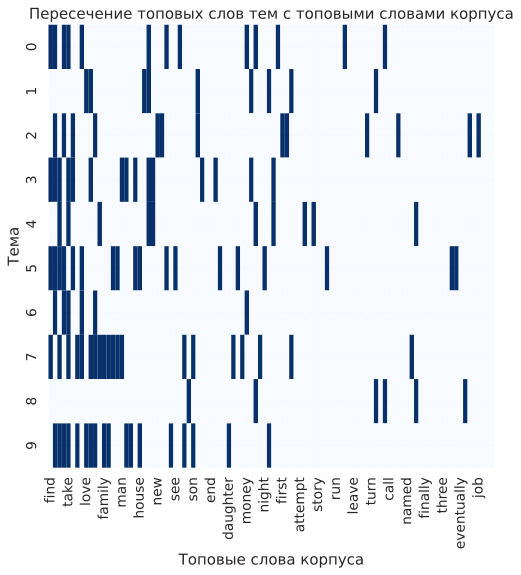

In [60]:
intersection_matrix = pd.DataFrame(0, index=range(n_topics), columns=top_n_words)

for topic_idx, words in enumerate(topics_top_words):
    for word in words:
        if word in top_n_words:
            intersection_matrix.at[topic_idx, word] = 1

# Визуализация матрицы пересечений
plt.figure(figsize=(8, 8))
sns.heatmap(intersection_matrix, cmap='Blues', cbar=False)
plt.title('Пересечение топовых слов тем с топовыми словами корпуса')
plt.xlabel('Топовые слова корпуса')
plt.ylabel('Тема')
plt.show()

In [63]:
threshold = 0.8  # 80%

# Определим темы с долей общих слов выше порога
general_lexicon_topics = []
for topic_idx, common_words in common_word_topics.items():
    proportion = len(common_words) / n_top_words_analysis
    if proportion >= threshold:
        general_lexicon_topics.append((topic_idx, proportion, common_words))

if general_lexicon_topics:
    print("\nТемы с общей лексикой:")
    for topic_idx, proportion, words in general_lexicon_topics:
        print(f"Тема {topic_idx}: {proportion*100:.2f}% общих слов - {words}")
else:
    print("\nТем с общей лексикой не обнаружено.")


Темы с общей лексикой:
Тема 5: 90.00% общих слов - {'one', 'find', 'go', 'try', 'next', 'see', 'away', 'begin', 'house', 'tell', 'get', 'say', 'night', 'time', 'home', 'back', 'room', 'later'}
Тема 7: 100.00% общих слов - {'girl', 'man', 'family', 'child', 'son', 'back', 'two', 'young', 'boy', 'father', 'year', 'one', 'find', 'friend', 'life', 'take', 'mother', 'day', 'time', 'home'}
Тема 9: 90.00% общих слов - {'mother', 'one', 'fall', 'go', 'family', 'friend', 'meet', 'house', 'daughter', 'life', 'get', 'son', 'day', 'love', 'father', 'come', 'also', 'take'}


**Видно, что темы 5, 7 и 9 имеют много общей лексики, связанной с семейными отношениями**

## Упрощенная модель LDA (у каждого документа только одна тема)

Теперь обучим упрощенную модель LDA, разобранную на семинаре. В данной модели одному документу соответсвует одна тема. Вероятностная модель выглядит следующим образом:

Случайные величины:
* $w_{dn}$ -- слово, стоящее на $n$-ой позиции в документе $d$ (наблюдаемая случайная величина)
* $t_d$ -- тема документа $d$ (латентная случайная величина)

Параметры модели:
* $\Phi = \{\phi_{tw}\} \in \mathbb{R}^{T\times V}$ -- матрица распределений слов по темам  ($T$ -- число тем, $V$ -- размер словаря)
* $\pi \in \mathbb{R}^T$ -- вектор распределения тем в корпусе документов 

Совместное распределение на слова в документах и темы документов задается следующим образом:

$p(W, t \;|\; \Phi, \pi) = p(W \;|\; t, \Phi) p(t \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d}p(w_{dn}\;|\;t_d, \Phi) p(t_d \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d} \phi_{t_d w_{dn}}\pi_{t_d}$

Поскольку в модели присутствуют латентные переменные, оптимизацию параметров мы будем вести с помощью ЕМ-алгоритма:
* **E-шаг:**  $KL(q(t) \;||\; p(t\;|\; W, \Phi, \pi) ) \to \min_{q(t)}$
* **M-шаг:** $\mathbb{E}_{q(t)} \log p(W, t \;|\; \Phi, \pi) \to \max_{\Phi, \pi}$

**Задание 3**

Выведите формулы для нахождения $q(t_d = t) = \mu_{dt},\;\Phi,\;\pi$ и оптимизируемого функционала ELBO

In [ ]:
# Решение ниже

#### E-шаг: Обновление $q(t_d = t) = \mu_{dt}$

Для $q(t_d = t)$, мы минимизируем дивергенцию Кульбака-Лейблера:

$$
KL(q(t) \mid\mid p(t \mid W, \Phi, \pi)) \to \min_{q(t)}.
$$

Используем формулу Байеса:

$$
p(t_d = t \mid W_d, \Phi, \pi) \propto p(W_d \mid t_d = t, \Phi) p(t_d = t \mid \pi).
$$

Подставляя вероятности:
1. $p(W_d \mid t_d = t, \Phi) = \prod_{n=1}^{N_d} \phi_{t w_{dn}}$,
2. $p(t_d = t \mid \pi) = \pi_t$.

Получаем:

$$
\mu_{dt} \propto \pi_t \prod_{n=1}^{N_d} \phi_{t w_{dn}}.
$$

**Нормировка** для получения вероятностей:

$$
\mu_{dt} = \frac{\pi_t \prod_{n=1}^{N_d} \phi_{t w_{dn}}}{\sum_{t'} \pi_{t'} \prod_{n=1}^{N_d} \phi_{t' w_{dn}}}.
$$

---

#### M-шаг: Обновление параметров $\Phi$ и $\pi$

**Вывод формулы для $\Phi$**

Целевая функция:

$$
\mathcal{L}(\Phi) = \mathbb{E}_{q(t)} \left[ \sum_{d=1}^D \sum_{n=1}^{N_d} \log \phi_{t_d w_{dn}} \right] 
$$

С использованием распределения $ q(t_d = t) = \mu_{dt}$:

$$\mathcal{L}(\Phi) = \sum_{d=1}^D \sum_{n=1}^{N_d} \sum_t \mu_{dt} \log \phi_{t w_{dn}}.$$

Используем условия Каруша-Куна-Таккера с ограничением $\sum_w \phi_{tw} = 1$ и запишем функцию Лагранжа:

$$L(\Phi, \lambda) = \mathcal{L}(\Phi) + \sum_t \lambda_t \left( \sum_w \phi_{tw} - 1 \right).$$

Производная по $\phi_{tw}$:

$$
\frac{\partial}{\partial \phi_{tw}} L(\Phi, \lambda) = \frac{\partial}{\partial \phi_{tw}} \left[ \sum_{d=1}^D \sum_{n=1}^{N_d} \sum_t \mu_{dt} \log \phi_{t w_{dn}} + \sum_t \lambda_t \left( \sum_w \phi_{tw} - 1 \right) \right] = 0.
$$

$$
\frac{\partial}{\partial \phi_{tw}} L(\Phi, \lambda) = \frac{\sum_{d=1}^D \mu_{dt} \sum_{n=1}^{N_d} \mathbb{I}(w_{dn} = w)}{\phi_{tw}} + \lambda_t = 0.
$$

Решение для $ \phi_{tw} $:

$$
\phi_{tw} \propto \sum_{d=1}^D \mu_{dt} \sum_{n=1}^{N_d} \mathbb{I}(w_{dn} = w).
$$

С учетом нормировки:

$$
\phi_{tw} = \frac{\sum_{d=1}^D \mu_{dt} \sum_{n=1}^{N_d} \mathbb{I}(w_{dn} = w)}{\sum_{d=1}^D \mu_{dt} N_d}.
$$

---

**Вывод формулы для $\pi$**

Целевая функция:

$$
\mathcal{L}(\pi) = \mathbb{E}_{q(t)} \left[ \sum_{d=1}^D \log \pi_{t_d} \right].
$$

С использованием распределения $ q(t_d = t) = \mu_{dt} $:

$$
\mathcal{L}(\pi) = \sum_{d=1}^D \sum_t \mu_{dt} \log \pi_t.
$$

Используем условия Каруша-Куна-Таккера с ограничением c ограничением $\sum_t \pi_t = 1 $ и запишем функцию Лагранжа:

$$
L(\pi, \lambda) = \mathcal{L}(\pi) + \lambda \left( \sum_t \pi_t - 1 \right).
$$

Производная по $\pi_t $:

$$
\frac{\partial}{\partial \pi_t} L(\pi, \lambda) = \frac{\partial}{\partial \pi_t} \left[ \sum_{d=1}^D \sum_t \mu_{dt} \log \pi_t + \lambda \left( \sum_t \pi_t - 1 \right) \right] = 0.
$$

$$
\frac{\partial}{\partial \pi_t} L(\pi, \lambda) = \frac{\sum_{d=1}^D \mu_{dt}}{\pi_t} + \lambda = 0.
$$

Решение для $\pi_t $:

$$
\pi_t \propto \sum_{d=1}^D \mu_{dt}.
$$

С учетом нормировки:

$$
\pi_t = \frac{\sum_{d=1}^D \mu_{dt}}{D}.
$$


---

#### Функционал ELBO

Функционал ELBO имеет вид:

$$
\text{ELBO} = \mathbb{E}_{q(t)} \log p(W, t \mid \Phi, \pi) - \mathbb{E}_{q(t)} \log q(t).
$$


$$
\mathbb{E}_{q(t)} \log p(W, t \mid \Phi, \pi) = \sum_{d=1}^D \sum_t \mu_{dt} \left[ \log \pi_t + \sum_{n=1}^{N_d} \log \phi_{t w_{dn}} \right].
$$


$$
\mathbb{E}_{q(t)} \log q(t) = \sum_{d=1}^D \sum_t \mu_{dt} \log \mu_{dt}.
$$

Полный функционал ELBO:

$$
\text{ELBO} = \sum_{d=1}^D \sum_t \mu_{dt} \left[ \log \pi_t + \sum_{n=1}^{N_d} \log \phi_{t w_{dn}} \right] - \sum_{d=1}^D \sum_t \mu_{dt} \log \mu_{dt}.
$$

---

#### Итоговые формулы

1. **E-шаг (обновление $\mu_{dt}$):**

$$
\mu_{dt} = \frac{\pi_t \prod_{n=1}^{N_d} \phi_{t w_{dn}}}{\sum_{t'} \pi_{t'} \prod_{n=1}^{N_d} \phi_{t' w_{dn}}}.
$$

2. **M-шаг (обновление $\Phi$ и $\pi$):**

$$
\phi_{tw} = \frac{\sum_{d=1}^D \mu_{dt} \sum_{n=1}^{N_d} \mathbb{I}(w_{dn} = w)}{\sum_{d=1}^D \mu_{dt} N_d},
$$

$$
\pi_t = \frac{1}{D} \sum_{d=1}^D \mu_{dt}.
$$

3. **Функционал ELBO:**

$$
\text{ELBO} = \sum_{d=1}^D \sum_t \mu_{dt} \left[ \log \pi_t + \sum_{n=1}^{N_d} \log \phi_{t w_{dn}} \right] - \sum_{d=1}^D \sum_t \mu_{dt} \log \mu_{dt}.
$$

**Задание 4**

Реализуйте упрощенный LDA

**Подсказка:** Если вам нужно будет посчитать $\log Softmax$, лучше воспользуйтесь устойчивым способом подсчета из второй практической работы:

$$\alpha_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\alpha_i}}{\sum_k e^{\alpha_k}} = 
	\frac{e^{(\alpha_i - \max_j \alpha_j)}}{\sum_k e^{(\alpha_k- \max_j \alpha_j)}}$$

In [76]:
class SimpleLDA(object):
    def __init__(self, n_topics, epsilon=1e-15, tol=1e-5, verbose_step=50):
        self.n_topics = n_topics
        self.epsilon = epsilon
        self.tol = tol
        self.verbose_step = verbose_step
        
    def fit(self, bow, verbose=True):
        self._initialize(bow)
        elbo = -np.inf
        for it in range(1000):
            self._e_step(bow)
            self._m_step(bow)
            new_elbo = self._count_elbo(bow)
            diff = new_elbo - elbo
            if verbose and (it + 1) % self.verbose_step == 0:
                print("\n{}:\n elbo: {}\n increase: {}".format(it + 1, new_elbo, diff))
            if diff < self.tol:
                break
            elbo = new_elbo
            
    def _initialize(self, bow):
        self.D, self.V = bow.shape
        self.mu = np.zeros((self.D, self.n_topics))
        self.pi = np.abs(np.random.randn(self.n_topics))
        self.pi = self.pi / self.pi.sum()
        self.phi = np.abs(np.random.randn(self.n_topics, self.V))
        self.phi = self.phi / self.phi.sum(axis=1)[:, np.newaxis]
        
    def _e_step(self, bow):
        log_phi = np.log(self.phi + self.epsilon)
        log_pi = np.log(self.pi + self.epsilon)
        alpha = log_pi + bow @ log_phi.T
        alpha -= np.max(alpha, axis=1, keepdims=True)
        self.mu = np.exp(alpha)
        self.mu /= self.mu.sum(axis=1, keepdims=True)

    def _m_step(self, bow):
        self.pi = self.mu.sum(axis=0) / self.D
        self.phi = self.mu.T @ bow
        self.phi += self.epsilon 
        self.phi /= self.phi.sum(axis=1, keepdims=True)
    
    def _count_elbo(self, bow):
        log_phi = np.log(self.phi + self.epsilon)  
        log_pi = np.log(self.pi + self.epsilon)   
        log_theta = log_pi + bow @ log_phi.T 
        elbo = np.sum(self.mu * log_theta) 
        elbo -= np.sum(self.mu * np.log(self.mu + self.epsilon))
    
        return elbo

**Задание 5**

Обучите упрощенный LDA и посмотрите на самые вероятные слова в каждой теме. Насколько различные получились темы? Насколько интерпретируемые? Сравните их с темами, полученными в классической модели LDA. 

In [77]:
# Обучаем модель
simple_lda = SimpleLDA(n_topics=10)
simple_lda.fit(count_data)

# Получаем топовые слова
n_top_words = 10
words = count_vectorizer.get_feature_names_out()

print("\nТоповые слова по темам для упрощённой модели LDA:")
for topic_idx, topic in enumerate(simple_lda.phi):
    top_words = [words[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    print(f"Тема {topic_idx}: {', '.join(top_words)}")


50:
 elbo: -55036178.17854636
 increase: 252.51016800105572

100:
 elbo: -55030572.9719616
 increase: 35.98100842535496

150:
 elbo: -55029280.02959875
 increase: 37.6089968457818

200:
 elbo: -55028963.616396196
 increase: 30.437893487513065

250:
 elbo: -55028640.903018296
 increase: 0.29901423305273056

300:
 elbo: -55028443.30711724
 increase: 0.009732402861118317

350:
 elbo: -55028374.94035251
 increase: 2.5890767574310303e-05

400:
 elbo: -55028348.39556255
 increase: 0.00023663043975830078

Топовые слова по темам для упрощённой модели LDA:
Тема 0: one, find, go, take, police, get, two, back, friend, father
Тема 1: get, love, father, life, one, family, come, friend, go, take
Тема 2: find, one, kill, police, back, take, two, escape, get, go
Тема 3: find, one, take, life, love, tell, return, back, man, film
Тема 4: life, one, tell, find, go, father, love, family, new, take
Тема 5: one, take, find, men, back, kill, two, return, escape, war
Тема 6: tom, jerry, go, back, get, find, 

In [79]:
def compare_topics(topics_1, topics_2):
    """
    Сравнивает темы из двух моделей и выводит долю пересечений.
    topics_1 и topics_2 — списки топовых слов по темам.
    """
    print("Сравнение тем между моделями:")
    for i, (topic1, topic2) in enumerate(zip(topics_1, topics_2)):
        intersection = set(topic1) & set(topic2)
        print(f"Тема {i}: пересечение {len(intersection)}/{len(topic1)} слов")
        print(f"  Упрощённая LDA: {', '.join(topic1)}")
        print(f"  Классическая LDA: {', '.join(topic2)}")
        print(f"  Общие слова: {', '.join(intersection)}\n")

# Получаем топ-слова из упрощённой модели LDA
n_top_words = 10
topics_simplified = []

for topic_idx in range(simple_lda.n_topics):
    top_word_indices = simple_lda.phi[topic_idx].argsort()[::-1][:n_top_words]  # Индексы топ-слов
    top_words = [words[i] for i in top_word_indices]  # Получаем слова по индексам
    topics_simplified.append(top_words)

# Получаем топ-слова из классической модели LDA
topics_classical = [
    [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    for topic in lda.components_
]

# Сравниваем темы
compare_topics(topics_simplified, topics_classical)

Сравнение тем между моделями:
Тема 0: пересечение 4/10 слов
  Упрощённая LDA: one, find, go, take, police, get, two, back, friend, father
  Классическая LDA: tom, get, sam, money, kill, go, take, fight, bank, find
  Общие слова: get, find, go, take

Тема 1: пересечение 2/10 слов
  Упрощённая LDA: get, love, father, life, one, family, come, friend, go, take
  Классическая LDA: king, love, film, anna, lord, prince, london, return, life, queen
  Общие слова: love, life

Тема 2: пересечение 1/10 слов
  Упрощённая LDA: find, one, kill, police, back, take, two, escape, get, go
  Классическая LDA: new, film, show, school, paul, john, work, job, go, make
  Общие слова: go

Тема 3: пересечение 3/10 слов
  Упрощённая LDA: find, one, take, life, love, tell, return, back, man, film
  Классическая LDA: police, murder, man, find, death, wife, kill, case, one, killed
  Общие слова: man, one, find

Тема 4: пересечение 0/10 слов
  Упрощённая LDA: life, one, tell, find, go, father, love, family, new, ta

In [81]:
from scipy.optimize import linear_sum_assignment

def compute_intersection_matrix(topics_1, topics_2):
    n1, n2 = len(topics_1), len(topics_2)
    intersection_matrix = np.zeros((n1, n2), dtype=int)

    for i, topic1 in enumerate(topics_1):
        for j, topic2 in enumerate(topics_2):
            intersection_matrix[i, j] = len(set(topic1) & set(topic2))

    return intersection_matrix

def match_topics(topics_1, topics_2, n_top_words=10):
    """
    Сопоставляет темы на основе пересечений слов и выводит результат.
    """
    intersection_matrix = compute_intersection_matrix(topics_1, topics_2)
    
    row_ind, col_ind = linear_sum_assignment(-intersection_matrix)

    print("Сопоставление тем между моделями на основе максимального пересечения слов:")
    for i, j in zip(row_ind, col_ind):
        intersection = set(topics_1[i]) & set(topics_2[j])
        print(f"\nТема упрощённой LDA {i} и Тема классической LDA {j}: пересечение {len(intersection)}/{n_top_words}")
        print(f"  Упрощённая LDA: {', '.join(topics_1[i])}")
        print(f"  Классическая LDA: {', '.join(topics_2[j])}")
        print(f"  Общие слова: {', '.join(intersection)}")

n_top_words = 10
topics_simplified = [
    [words[i] for i in simple_lda.phi[topic_idx].argsort()[:-n_top_words-1:-1]]
    for topic_idx in range(simple_lda.n_topics)
]

topics_classical = [
    [words[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    for topic in lda.components_
]

match_topics(topics_simplified, topics_classical, n_top_words)

Сопоставление тем между моделями на основе максимального пересечения слов:

Тема упрощённой LDA 0 и Тема классической LDA 8: пересечение 0/10
  Упрощённая LDA: one, find, go, take, police, get, two, back, friend, father
  Классическая LDA: ship, war, soldier, army, force, attack, island, captain, crew, battle
  Общие слова: 

Тема упрощённой LDA 1 и Тема классической LDA 9: пересечение 7/10
  Упрощённая LDA: get, love, father, life, one, family, come, friend, go, take
  Классическая LDA: love, get, father, friend, family, come, life, son, marriage, day
  Общие слова: family, friend, get, love, father, come, life

Тема упрощённой LDA 2 и Тема классической LDA 3: пересечение 4/10
  Упрощённая LDA: find, one, kill, police, back, take, two, escape, get, go
  Классическая LDA: police, murder, man, find, death, wife, kill, case, one, killed
  Общие слова: kill, one, find, police

Тема упрощённой LDA 3 и Тема классической LDA 1: пересечение 4/10
  Упрощённая LDA: find, one, take, life, love, 

Темы из упрощённой LDA имеют больше общих слов и кажутся менее разнообразными. Часто встречаются универсальные слова вроде find, go, take, что делает темы менее специфичными.

Классическая LDA, напротив, выделяет более чёткие и уникальные темы, например, военные (ship, war, soldier) или семейные (father, family, son).

Если нужен быстрый анализ основных смыслов, упрощённая LDA подойдёт. Для более детального анализа лучше использовать классическую LDA.


**Задание 6**

У упрощенной модели LDA могли возникнуть проблемы из-за слов общей лексики. Попробуйте отбросить из словаря слова, которые встречаются больше, чем в 10% документов и обучить упрощенный LDA на этих данных. Посмотрите на получившиеся темы. Как они отличаются от тем модели, обученной на словаре с общей лексикой? Чем объясняются эти различия? Почему у стандартной модели LDA возникает меньше проблем со словами общей лексики?

In [89]:
word_counts = (count_data > 0).sum(axis=0).A1  # Частота встречаемости в документах
word_frequencies = word_counts / count_data.shape[0]  # Доля документов, содержащих слово

# Оставляем слова, встречающиеся в <= 10% документов
vocab_mask = word_frequencies < 0.1
filtered_words = np.array(count_vectorizer.get_feature_names_out())[vocab_mask]
filtered_count_data = count_data[:, vocab_mask]

In [90]:
# Обучаем модель
simple_lda_filtered = SimpleLDA(n_topics=10)
simple_lda_filtered.fit(filtered_count_data)

# Получаем топовые слова
n_top_words = 10
words = count_vectorizer.get_feature_names_out()


50:
 elbo: -42621225.22298899
 increase: 206.04198297858238

100:
 elbo: -42613954.204362735
 increase: 26.81573973596096

150:
 elbo: -42612972.55054226
 increase: 2.770297162234783

200:
 elbo: -42612679.31126388
 increase: 0.2961924150586128

250:
 elbo: -42612655.528487906
 increase: 1.0630397573113441

300:
 elbo: -42612566.924779244
 increase: 0.15089671313762665

350:
 elbo: -42612556.06624759
 increase: 0.0033513158559799194


In [91]:
n_top_words = 10
topics_simplified_filtered = [
    [filtered_words[i] for i in simple_lda_filtered.phi[topic_idx].argsort()[:-n_top_words-1:-1]]
    for topic_idx in range(simple_lda_filtered.n_topics)
]

match_topics(topics_simplified_filtered, topics_classical, n_top_words)

Сопоставление тем между моделями на основе максимального пересечения слов:

Тема упрощённой LDA 0 и Тема классической LDA 4: пересечение 2/10
  Упрощённая LDA: john, team, mary, play, paul, bill, game, york, win, johnny
  Классическая LDA: kill, team, escape, men, gang, shoot, car, killed, gun, game
  Общие слова: game, team

Тема упрощённой LDA 1 и Тема классической LDA 0: пересечение 1/10
  Упрощённая LDA: tom, jack, jerry, david, john, harry, nick, apartment, michael, sex
  Классическая LDA: tom, get, sam, money, kill, go, take, fight, bank, find
  Общие слова: tom

Тема упрощённой LDA 2 и Тема классической LDA 5: пересечение 0/10
  Упрощённая LDA: jim, larry, hospital, steven, mary, ajay, luke, movie, ella, alex
  Классическая LDA: find, house, back, go, tell, see, night, room, one, body
  Общие слова: 

Тема упрощённой LDA 3 и Тема классической LDA 2: пересечение 1/10
  Упрощённая LDA: anna, michael, frank, john, joe, george, annie, hospital, james, baby
  Классическая LDA: new, f

**Как отличаются темы?**

После удаления общей лексики темы стали более специфичными и осмысленными.

Пропали слова вроде find, go, take, которые размывали смысл тем.
Темы стали включать уникальные термины, например, ship, war, soldier (военная тема) или gang, hong, kong (тема боевых искусств).
В темах с общей лексикой встречались слишком частые слова, которые затрудняли выделение конкретных сюжетов.

**Чем объясняются эти различия?**

Различия связаны с тем, что общая лексика присутствует во многих документах, из-за чего упрощённая модель "забивалась" ими, создавая менее специфичные темы. После их удаления модель смогла сосредоточиться на менее частых, но более характерных для документов словах.

**Почему стандартная LDA лучше справляется с общей лексикой?**

Стандартная LDA распределяет вероятность каждого слова между темами. Даже если слово часто встречается, модель понимает его контекст и относит его к разным темам. Это предотвращает доминирование общей лексики и позволяет выделять более осмысленные темы.